# Median Mosaic

_by Alex Berndt 13 Dec 2021_

__Abstract__

This notebook includes the [example code of a Planetary Computer](https://planetarycomputer.microsoft.com/docs/tutorials/cloudless-mosaic-sentinel2/) tutorial on creating a _cloudless mosaic_.

In [2]:
import numpy as np
import xarray as xr

import coiled
import rasterio.features
import stackstac
import pystac_client
import planetary_computer
import dask.distributed

import stackstac
import pystac_client
from rasterio.enums import Resampling

import xrspatial.multispectral as ms

## Start Dask Cluster

Using Dask Cluster hosted by coiled.

In [3]:
# Create a remote Dask cluster with Coiled
cluster = coiled.Cluster(
    name="stackstac",
    software="gjoseph92/stackstac",
    n_workers=8,
)

# Connect Dask to that cluster
client = dask.distributed.Client(cluster)
print("Dask Dashboard:", client.dashboard_link)

Output()

Found software environment build
Created fw rule: inbound [22-22] [0.0.0.0/0] []
Created fw rule: inbound [8786-8786] [0.0.0.0/0] []
Created fw rule: inbound [8787-8787] [0.0.0.0/0] []
Created FW rules: coiled-dask-graphif92-78780-firewall
Created fw rule: inbound [0-65535] [None] [coiled-dask-graphif92-78780-firewall]
Created scheduler VM: coiled-dask-graphif92-78780-scheduler (type: t3.medium, ip: ['100.26.3.198'])


Dask Dashboard: http://100.26.3.198:8787


/home/alex/anaconda3/envs/coiled-coiled-default/lib/python3.9/site-packages/distributed/client.py:1131: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| blosc   | 1.10.2 | None      | None    |
| lz4     | 3.1.10 | None      | None    |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


### Search Through Data

In [4]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.27508544921875, 47.54687159892238],
            [-121.96128845214844, 47.54687159892238],
            [-121.96128845214844, 47.745787772920934],
            [-122.27508544921875, 47.745787772920934],
            [-122.27508544921875, 47.54687159892238],
        ]
    ],
}
bbox = rasterio.features.bounds(area_of_interest)

In [5]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    datetime="2020-01-01/2020-12-31",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 25}},
)

items = list(search.get_items())
print(len(items))

36


In [6]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [7]:
data = (
    stackstac.stack(
        signed_items,
        assets=["B04", "B03", "B02"],  # red, green, blue
        chunksize=4096,
        resolution=100,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)
data

,Array,Chunk
Bytes,0.97 GiB,9.21 MiB
Shape,"(36, 3, 1099, 1099)","(1, 1, 1099, 1099)"
Count,541 Tasks,108 Chunks
Type,float64,numpy.ndarray


In [8]:
data = data.persist()

## Calculate Median Composite

In [9]:
median = data.median(dim="time").compute()

In [10]:
image = ms.true_color(*median)  # expects red, green, blue DataArrays

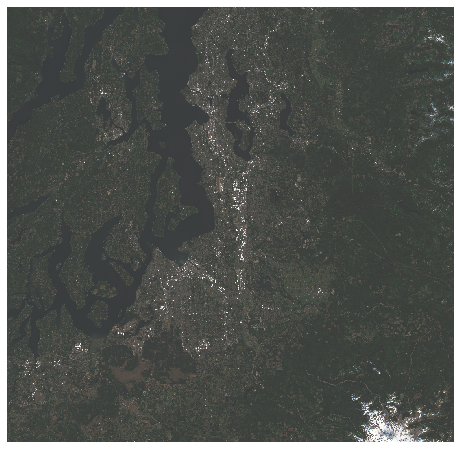

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

ax.set_axis_off()
image.plot.imshow(ax=ax);

## Monthly Composite

In [12]:
monthly = data.groupby("time.month").median().compute()

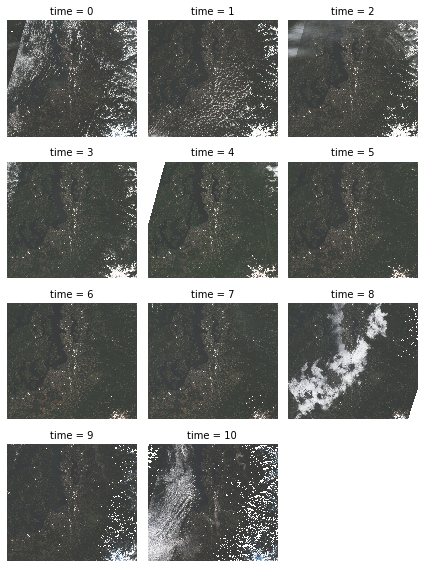

In [13]:
images = [ms.true_color(*x) for x in monthly]
images = xr.concat(images, dim="time")

g = images.plot.imshow(x="x", y="y", rgb="band", col="time", col_wrap=3, figsize=(6, 8))
for ax in g.axes.flat:
    ax.set_axis_off()

plt.tight_layout()

## Shutdown Dask Cluster

Important! Don't forget to shut down the cluster using the following commands:

In [14]:
coiled.list_clusters()

{'stackstac': {'id': 78780,
  'status': 'running',
  'account': 'graphific',
  'private_address': 'tls://10.4.10.99:8786',
  'dashboard_address': 'http://100.26.3.198:8787',
  'configuration': 434,
  'vm_type': 't3.medium',
  'workers': [{'name': 'coiled-dask-graphif92-78780-worker-a739938e15',
    'status': 'running',
    'vm_type': 't3.large'},
   {'name': 'coiled-dask-graphif92-78780-worker-08465a8a77',
    'status': 'running',
    'vm_type': 't3.large'},
   {'name': 'coiled-dask-graphif92-78780-worker-71ea5880c9',
    'status': 'running',
    'vm_type': 't3.large'},
   {'name': 'coiled-dask-graphif92-78780-worker-325cfdd931',
    'status': 'running',
    'vm_type': 't3.large'},
   {'name': 'coiled-dask-graphif92-78780-worker-71786bbbb1',
    'status': 'running',
    'vm_type': 't3.large'},
   {'name': 'coiled-dask-graphif92-78780-worker-5ac3bfdec1',
    'status': 'running',
    'vm_type': 't3.large'},
   {'name': 'coiled-dask-graphif92-78780-worker-e75031566f',
    'status': 'runni

In [15]:
coiled.delete_cluster(name="stackstac")  # Add your cluster name here
# client.close()  # Close the client as well

Cluster deleted successfully.

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.deploy.cluster - WARNING - Failed to sync cluster info multiple times - perhaps there's a connection issue? Error:
Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/coiled-coiled-default/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/alex/anaconda3/envs/coiled-coiled-default/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/coiled-coiled-default/lib/python3.9/asyncio/tasks.py",